# Practica Fifa 


##  Intel·ligència Artificial. Grup 1 UIB


Lluc Valdés Carrasco

[Repository Github](https://github.com/LlucValdes/PracticaFifa)


Importam les llibreries necesaries


In [ ]:
import os
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Llegim les dades de el .csv

In [ ]:
df = pd.read_csv(os.path.join("..", "in", "/fifa.csv"))

Anam a veure com son les dades.

In [ ]:
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M




Aquí podem veure que hi ha moltes columnes que no ens donaran cap informació com poden ser les tres primeres, la de Photo, la de Flag o la de Club Logo així que les llevarem.



In [ ]:
df = df.drop(columns =  ["Unnamed: 0","ID","Name","Photo","Flag","Club Logo"],axis=1)




No seran les úniques columnes que acabarem llevant, però eren les que no tenien res a veure amb el valor del jugador.


És necessari canviar totes les columnes com value o wage, ja que ara mateix són strings i volem que siguin números.


Això o farem amb la funció feta pel professor.



In [ ]:
def value_to_float(x):
    """
    From K and M to float.
    
    """
    x = x.replace('€', '')
    ret_val = 0.0
    
    if type(x) == float or type(x) == int:
        ret_val = x
    if 'K' in x:
        if len(x) > 1:
            ret_val = float(x.replace('K', ''))
        ret_val = ret_val *1000
    if 'M' in x:
        if len(x) > 1:
            ret_val = float(x.replace('M', ''))
        ret_val = ret_val * 1000000.0
    return ret_val

In [ ]:
df["Value"] = df["Value"].apply(value_to_float)
df["Wage"] = df["Wage"].apply(value_to_float)
df["Release Clause"].fillna("0",inplace = True)
df["Release Clause"] = df["Release Clause"].apply(value_to_float)

També hi ha un problema amb la columna Loaned From, ja que té molts de NaN (Si un jugador no està cedit surt NaN).


Podríem fer dues coses, eliminar la columna. O si és probable que hi hagi una relació amb el preu del jugador guardar aquesta informació d'un altra manera.


Jo he optat per la primera solució.

In [ ]:
df = df.drop(columns =  ["Loaned From"],axis=1)

Tant la columna club com a nacionalitat s'han de modificar per poder emprar-les, i que la informació que donin sigui útil. Per això emprarem onehot encoding.

In [ ]:
clb = df.pop("Club")
df = pd.concat([df.reset_index(drop=True), pd.get_dummies(clb, prefix='clb').reset_index(drop=True)], axis=1, sort=False)
nat = df.pop("Nationality")
df = pd.concat([df.reset_index(drop=True), pd.get_dummies(nat, prefix='nat').reset_index(drop=True)], axis=1, sort=False)
df.head()

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,...,nat_Puerto Rico,nat_Qatar,nat_Republic of Ireland,nat_Romania,nat_Russia,nat_Rwanda,nat_Saudi Arabia,nat_Scotland,nat_Senegal,nat_Serbia,nat_Sierra Leone,nat_Slovakia,nat_Slovenia,nat_South Africa,nat_South Sudan,nat_Spain,nat_St Kitts Nevis,nat_St Lucia,nat_Sudan,nat_Suriname,nat_Sweden,nat_Switzerland,nat_Syria,nat_São Tomé & Príncipe,nat_Tanzania,nat_Thailand,nat_Togo,nat_Trinidad & Tobago,nat_Tunisia,nat_Turkey,nat_Uganda,nat_Ukraine,nat_United Arab Emirates,nat_United States,nat_Uruguay,nat_Uzbekistan,nat_Venezuela,nat_Wales,nat_Zambia,nat_Zimbabwe
0,31,94,94,110500000.0,565000.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33,94,94,77000000.0,405000.0,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26,92,93,118500000.0,290000.0,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,27,91,93,72000000.0,260000.0,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27,91,92,102000000.0,355000.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.corr()

,Age,Overall,Potential,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,...,nat_Puerto Rico,nat_Qatar,nat_Republic of Ireland,nat_Romania,nat_Russia,nat_Rwanda,nat_Saudi Arabia,nat_Scotland,nat_Senegal,nat_Serbia,nat_Sierra Leone,nat_Slovakia,nat_Slovenia,nat_South Africa,nat_South Sudan,nat_Spain,nat_St Kitts Nevis,nat_St Lucia,nat_Sudan,nat_Suriname,nat_Sweden,nat_Switzerland,nat_Syria,nat_São Tomé & Príncipe,nat_Tanzania,nat_Thailand,nat_Togo,nat_Trinidad & Tobago,nat_Tunisia,nat_Turkey,nat_Uganda,nat_Ukraine,nat_United Arab Emirates,nat_United States,nat_Uruguay,nat_Uzbekistan,nat_Venezuela,nat_Wales,nat_Zambia,nat_Zimbabwe
Age,1.000000,0.452350,-0.253312,0.075022,0.141145,0.236695,0.253765,0.059867,0.027649,-0.241156,0.130545,0.068660,0.147183,0.132894,0.142472,0.010166,0.143276,0.193467,0.181310,0.084969,-0.158667,-0.151682,-0.019395,0.453124,-0.089877,0.156947,0.177167,0.097793,0.332798,0.155096,0.265190,0.197845,0.082443,0.187422,0.139535,0.391023,0.142817,0.119745,0.103089,0.101277,...,0.014090,-0.001781,-0.013955,0.003331,-0.002264,-0.006542,-0.016642,-0.005103,0.004346,0.009307,-0.001123,0.013496,0.015919,0.017423,-0.000194,0.010892,0.003329,-0.001781,0.003329,0.000406,-0.009061,-0.011398,0.004180,0.009328,-0.008583,-0.000434,0.017201,0.021039,0.012099,-0.011403,-0.005011,0.000201,0.001393,-0.000950,0.028955,0.009826,-0.010526,-0.006978,-0.013810,0.009868
Overall,0.452350,1.000000,0.660939,0.627085,0.571926,0.606960,0.499491,0.212015,0.414463,-0.218931,0.394972,0.332515,0.340776,0.502550,0.391338,0.372426,0.419491,0.396892,0.483909,0.460197,0.196869,0.210647,0.264952,0.850045,0.103160,0.441118,0.264435,0.365656,0.349326,0.420795,0.395470,0.321326,0.356493,0.498894,0.341429,0.727655,0.286505,0.252629,0.222811,-0.025937,...,-0.003474,-0.003474,-0.111282,0.023115,0.036545,-0.003474,-0.109241,-0.041319,0.029173,0.044585,-0.002379,0.017121,0.026202,0.011232,-0.006692,0.125266,-0.007876,-0.002402,-0.006637,0.001633,-0.056545,-0.012189,0.007458,0.006180,0.001415,-0.009209,0.018938,0.001097,0.012216,-0.003127,-0.009825,0.038442,0.011544,-0.021694,0.055101,0.001914,0.009060,-0.025667,-0.003272,0.013660
Potential,-0.253312,0.660939,1.000000,0.576218,0.486413,0.383727,0.372993,0.162346,0.354290,-0.010474,0.246319,0.243355,0.200988,0.369189,0.254906,0.315019,0.279944,0.230544,0.321437,0.354396,0.234608,0.236771,0.222310,0.513425,0.138025,0.288318,0.109151,0.202563,0.075769,0.266740,0.171174,0.154908,0.245616,0.348141,0.224281,0.440008,0.162801,0.143564,0.128980,-0.053446,...,-0.010033,-0.003994,-0.103425,0.020971,0.043403,-0.000371,-0.111046,-0.021371,0.022330,0.031881,-0.001402,0.013235,0.012901,-0.007729,-0.010033,0.134891,-0.016682,-0.003994,-0.011103,-0.004366,-0.057609,0.012157,0.000497,0.000837,0.005633,-0.013795,0.006735,-0.011009,0.000036,0.010207,-0.008799,0.039173,0.008083,-0.018142,0.030720,-0.006503,0.018243,-0.018423,0.008953,0.005028
Value,0.075022,0.627085,0.576218,1.000000,0.858442,0.377738,0.653176,0.165221,0.315651,-0.095132,0.249785,0.256665,0.184437,0.327623,0.288243,0.272004,0.287235,0.265773,0.302175,0.308818,0.170603,0.172677,0.194259,0.540552,0.113726,0.281360,0.124515,0.210721,0.128924,0.279730,0.184639,0.140666,0.259391,0.357639,0.239033,0.450352,0.133862,0.108402,0.087735,-0.028596,...,-0.003048,-0.002630,-0.044644,-0.002384,0.009764,-0.002564,-0.049167,-0.026822,0.017194,0.026068,-0.004278,0.013798,0.020256,-0.014231,-0.002849,0.088520,-0.003183,-0.002531,-0.004484,-0.004085,-0.033977,-0.005755,0.002278,0.000516,0.002901,-0.005690,0.006243,0.000104,-0.002532,-0.012284,-0.006028,0.019071,0.010716,-0.030838,0.038972,0.001291,-0.001883,-0.009892,-0.005093,0.001768
W



# Anem a mirar quines columnes queden que necessitin algun canvi:


**PreferedFoot:** Hauria de passar de ser un string a una altra cosa, es podria emprar one-hot.


**Work Rate:** Fer dues columnes una per atac que es el primer valor, i un altre per defensa que és el segon valor, on Low = 1, Medium = 2, High = 3.


**Body Type:** Eliminarla o fer one-hot.


**Real Face:** Canviar els yes per 1 i el no per 0, és probable que els jugadors que tenen photo sigui perquè són coneguts.


**Jersey Number:** Abans he decidit deixar-ho perquè alomillor els nombres més baixos tenien valors més alts. Ja que solen ser els jugadors titulars, però com es pot veure dalt la correlació és de 0,09 així que no és molt útil. Així que ho llevaré.


**Joined:** Segurament no ens sigui molt útil (Messi va entrar molt prest i és molt car i en Ronaldo fa poc i també és molt car) així que ho llevarem.


**Contract Valid Until:** Tampoc ens afectarà molt, ja que no hi ha molts d'anys de diferència als contractes així que tambe ho llevarem.


**Height i Weight:** Els modificarem perquè no siguin strings


**Position:** Podem llevar aquesta columna si arreglam les de LS, ST, etc. Per la qual cosa hauríem de fer la mitja i posar-la als porters. Així que les llevarem i farem one hot de position



**Prefered Foot**

In [ ]:
pf = df.pop("Preferred Foot")
df = pd.concat([df.reset_index(drop=True), pd.get_dummies(pf, prefix='pf').reset_index(drop=True)], axis=1, sort=False)

**Work Rate**

In [ ]:
def esforçAtac(x):
  
  x = x.split('/ ')
  if(x[0] == "Low"):
    return 1
  if(x[0] == "Medium"):
    return 2  
  if(x[0] == "High"):
    return 3 

In [ ]:
def esforçDefensa(x):
  x = x.split('/ ')
  if(x[1] == "Low"):
    return 1
  if(x[1] == "Medium"):
    return 2  
  if(x[1] == "High"):
    return 3 

In [ ]:
df["Work Rate"].fillna("Medium/ Medium",inplace = True)
EA = df.pop("Work Rate")
ED = EA.copy()

In [ ]:
df["EsforçAtac"] = EA.apply(esforçAtac)
df["EsforçDefensa"] = ED.apply(esforçDefensa)

**Body Type** 

In [ ]:
bt = df.pop("Body Type")
df = pd.concat([df.reset_index(drop=True), pd.get_dummies(bt, prefix='bt').reset_index(drop=True)], axis=1, sort=False)

**Real Face**

In [ ]:
df["Real Face"].unique()

array(['Yes', 'No', nan], dtype=object)

In [ ]:
df["Real Face"].fillna("No",inplace = True)
df["Real Face"].replace({"Yes": 1, "No": 0}, inplace=True)

**Jersey Number, Joined, Release Clause**

In [ ]:
df = df.drop(columns =  ["Jersey Number", "Joined", "Contract Valid Until"],axis=1)

**Heigth i Weight**

In [ ]:
def convertHeight(x):
  x.split("'")
  y = float(x[0]+"."+x[2])*30.48
  return y

In [ ]:
def convertWeight(x):
  x = x.replace('lbs','')
  y = float(x)/2.205
  return y

In [ ]:
df.dropna(subset=['Height'], inplace = True)
df["Height"] = df["Height"].apply(convertHeight)

df.dropna(subset=['Weight'], inplace = True)
df["Weight"] = df["Weight"].apply(convertWeight)

**Position**

In [ ]:
df = df.drop(columns =  ["LS","ST","RS","LW","LF","CF","RF","RW","LAM","CAM","RAM","LM","LCM","CM","RCM","RM","LWB","LDM","CDM","RDM","RWB","LB","LCB","CB","RCB","RB"],axis=1)
p = df.pop("Position")
df = pd.concat([df.reset_index(drop=True), pd.get_dummies(p, prefix='p').reset_index(drop=True)], axis=1, sort=False)
df

,Age,Overall,Potential,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Real Face,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,...,pf_Right,EsforçAtac,EsforçDefensa,bt_Akinfenwa,bt_C. Ronaldo,bt_Courtois,bt_Lean,bt_Messi,bt_Neymar,bt_Normal,bt_PLAYER_BODY_TYPE_25,bt_Shaqiri,bt_Stocky,p_CAM,p_CB,p_CDM,p_CF,p_CM,p_GK,p_LAM,p_LB,p_LCB,p_LCM,p_LDM,p_LF,p_LM,p_LS,p_LW,p_LWB,p_RAM,p_RB,p_RCB,p_RCM,p_RDM,p_RF,p_RM,p_RS,p_RW,p_RWB,p_ST
0,31,94,94,110500000.0,565000.0,2202,5.0,4.0,4.0,1,173.736,72.108844,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,...,0,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,33,94,94,77000000.0,405000.0,2228,5.0,4.0,5.0,1,188.976,82.993197,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,...,1,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,26,92,93,118500000.0,290000.0,2143,5.0,5.0,5.0,1,179.832,68.027211,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,...,1,3,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,27,91,93,72000000.0,260000.0,1471,4.0,3.0,1.0,1,195.072,76.190476,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,...,1,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27,91,92,102000000.0,355000.0,2281,4.0,5.0,4.0,1,155.448,69.841270,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,...,1,3,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18154,19,47,65,60000.0,1000.0,1307,1.0,2.0,2.0,0,179.832,60.770975,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,...,1,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18155,19,47,63,60000.0,1000.0,1098,1.0,2.0,2.0,0,192.024,77.097506,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,...,1,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18156,16,47,67,60000.0,1000.0,1189,1.0,3.0,2.0,0,176.784,67.120181,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,...,1,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18157,17,47,66,60000.0,1000.0,1228,1.0,3.0,2.0,0,155.448,69.841270,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,...,1,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Predicció

Normalització

In [ ]:
val = df.pop("Value")
#Es podria fer cross-validation pero el resultat es suficientment bo
X_train, X_test, y_train, y_test = train_test_split(df, val, test_size=0.33, random_state=42)
reg = linear_model.LinearRegression().fit(X_train, y_train)
preds = reg.predict(X_test)

In [ ]:
r2_score(preds, y_test)

0.9650461946761562



Això vol dir que aquesta predicció és bona, ja que com més s'atraca a 1 més petit és l'error, sent 1 una predicció sense error.



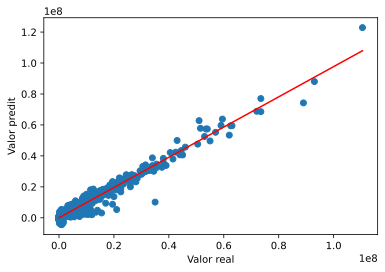

In [ ]:
plt.scatter(y_test,preds)
plt.xlabel('Valor real')
plt.ylabel('Valor predit')
plt.plot(np.unique(y_test),np.poly1d(np.polyfit(y_test, preds, 1))(np.unique(y_test)),color = 'red')
plt.show()



Podem veure com en general les prediccions tenen un marge d'error bastant petit, a part d'algun outlier com pot ser en Neymar que és el punt de més dalt a la dreta.

